# 2.03 Change Point Index Creator and Day Splitter

## Dataset Creator

In [19]:
import pandas as pd
import os
import sys
from datetime import datetime

def dataset_creator(raw_data_path='0_meal_identification/meal_identification/data/raw',
                    output_dir='0_meal_identification/meal_identification/data/interim',
                    use_auto_label=True,
                    keep_cols=['date', 'bgl', 'msg_type', 'affects_fob', 'affects_iob','dose_units','food_g','food_glycemic_index'],
                    day_start_index_change=True,
                    day_start_time=pd.Timedelta(hours=4),
                    min_carbs=10,
                    n_top_carb_meals=3,
                    meal_length=pd.Timedelta(hours=3),
                    erase_meal_overlap=True,
                    coerce_time=True,
                    coerse_time_interval=pd.Timedelta(minutes=5),
                    return_data=False,
                    ):
    '''
    Create a dataset from the raw data.

    Parameters
    ----------
    raw_data_path : str, optional
        Path to the directory containing raw data files (default is 'data/raw').
    output_dir : str, optional
        Directory to save the processed dataset (default is 'data/interm').
    use_auto_label : bool, optional
        Whether to use the auto label for the dataset (default is True).
    keep_cols : list of str, optional
        List of columns to keep from the raw data (default is ['date', 'bgl', 'msg_type', 'affects_fob', 'affects_iob', 'dose_units', 'food_g', 'food_glycemic_index']).
    day_start_index_change : bool, optional
        Whether to create a day index starting at a specific time (default is True).
    day_start_time : pd.Timedelta, optional
        The time of day to start the day index (default is pd.Timedelta(hours=4)).
    min_carbs : int, optional
        Minimum amount of carbohydrates to consider a meal (default is 10).
    n_top_carb_meals : int, optional
        Number of top carbohydrate meals to consider per day, keeps the 'n' largest aggregated meals (default is 3).
    meal_length : pd.Timedelta, optional
        Duration of a meal (default is pd.Timedelta(hours=3)).
    erase_meal_overlap : bool, optional
        Whether to erase overlapping meals (default is True).
    coerce_time : bool, optional
        Whether to use coarse time intervals (default is True).
    coerse_time_interval : pd.Timedelta, optional
        Interval for coarse time (default is pd.Timedelta(minutes=5)).
    return_data : bool, optional
        Whether to return the processed data (default is False).

    Returns
    -------
    None
        The function processes the raw data and saves the dataset to the specified output directory.
    '''

    def get_root_dir(current_dir=None):
        '''
        Get the root directory of the project by looking for a 'bg_control' directory.

        Parameters
        ----------
        current_dir : str, optional
            The starting directory to search from. If None, uses the current working directory.

        Returns
        -------
        str
            The root directory of the project.
        '''
        if current_dir is None:
            current_dir = os.getcwd()

        while current_dir != os.path.dirname(current_dir):
            if os.path.basename(current_dir) == 'bg_control':
                return current_dir
            current_dir = os.path.dirname(current_dir)

        raise FileNotFoundError("Project root directory 'bg_control' not found.")

    def load_data(raw_data_path, keep_cols):
        '''
        Load data from the raw data path.

        Parameters
        ----------
        raw_data_path : str
            Path to the directory containing raw data files.
        keep_cols : list of str
            List of columns to keep from the raw data.

        Returns
        -------
        dict
            A dictionary of DataFrames loaded from the raw data files.
        '''
        project_root = get_root_dir()
        print(project_root)
        full_raw_loc_path = os.path.join(project_root, raw_data_path)
        print(full_raw_loc_path)
        csv_files = [f for f in os.listdir(full_raw_loc_path) if f.endswith('.csv')]
        columns_to_load = keep_cols

        # Load each CSV file into a DataFrame and store them in a dictionary
        dataframes = {file: pd.read_csv(os.path.join(full_raw_loc_path, file), usecols=columns_to_load, parse_dates=['date']) for file in csv_files}
        print("Loaded DataFrames:", list(dataframes.keys()))

        return dataframes

    def save_data(data,
                  output_dir='0_meal_identification/meal_identification/data/interim',
                  data_label='dataLabelUnspecified_',
                  patient_id='idUnspecified_',
                  data_gen_date=datetime.today().strftime('%Y-%m-%d'),
                  inclue_gen_date_label=True):
        '''
        Save the data to the output directory

        Parameters
        ----------
        data : pd.DataFrame
            The data to save
        output_dir : str
            The directory to save the data
        data_label : str
            The label for the data
        patient_id : str
            The patient ID
        data_gen_date : str
            The date the data was generated
        inclue_gen_date_label : bool
            Whether to include the data generation date in the label

        Returns
        -------
        None
            The function saves the data to the specified output directory
        '''
        project_root = get_root_dir()
        print(f"Project root: {project_root}")
        full_out_path_dir = os.path.join(project_root, output_dir)
        if inclue_gen_date_label:
            data.to_csv(os.path.join(full_out_path_dir, f"{data_gen_date}_{patient_id}_{data_label}.csv"), index=True)
            print(f"Data saved successfully in: {output_dir}")
            print(f"\n \t Dataset label: {data_gen_date}_{patient_id}__{data_label}")
        else:
            data.to_csv(os.path.join(full_out_path_dir, f"{patient_id}_{data_label}.csv"), index=True)
            print(f"Data saved successfully in: {output_dir}")
            print(f"\n \t Dataset label: {patient_id}_{data_label}")

    def dataset_label_modifier_fn(base_label_modifer, coerce_time, coerce_time_label, day_start_index_change, day_start_time_label, erase_meal_overlap, erase_meal_label):
        '''
        Modify the data label

        Parameters
        ----------
        base_label_modifer : str
            The base label modifier for the dataset
        coerce_time : bool
            Whether to coerce the time interval of the data
        coerce_time_label : str
            The label modifier for the time interval coercion
        day_start_index_change : bool
            Whether to create a day index starting at a specific time
        day_start_time_label : str
            The label modifier for the day start time
        erase_meal_overlap : bool
            Whether to erase overlapping meals
        erase_meal_label : str
            The label modifier for the meal overlap erasure

        Returns
        -------
        str
            The modified data label
        '''
        data_label_modifer = base_label_modifer
        if coerce_time:
            data_label_modifer = data_label_modifer + coerce_time_label
        if day_start_index_change:
            data_label_modifer = data_label_modifer + day_start_time_label
        if erase_meal_overlap:
            data_label_modifer = data_label_modifer + erase_meal_label

        return data_label_modifer

    def coerce_time_fn(data, coerse_time_interval):
        '''
        Coerce the time interval of the data
        '''
        data = data.set_index('date').squeeze()
        data.index = pd.DatetimeIndex(data.index)

        meal_annoucements_df = data[data['msg_type'] == 'ANNOUNCE_MEAL']
        meal_annoucements_df = meal_annoucements_df.resample('5min').first()
        non_meal_df = data[data['msg_type'] != 'ANNOUNCE_MEAL']
        non_meal_df = non_meal_df.resample('5min').first()

        data_resampled = non_meal_df.join(meal_annoucements_df, how='left', rsuffix='_meal')
        data_resampled['bgl'] = data_resampled['bgl_meal'].combine_first(data_resampled['bgl'])
        data_resampled['msg_type'] = data_resampled['msg_type_meal'].combine_first(data_resampled['msg_type'])
        data_resampled['food_g'] = data_resampled['food_g_meal'].combine_first(data_resampled['food_g'])
        data_resampled['food_g_keep'] = data_resampled['food_g_meal']
        # Identify columns that end with '_meal'
        columns_to_drop = data_resampled.filter(regex='_meal$').columns

        # Drop the identified columns
        data_resampled = data_resampled.drop(columns=columns_to_drop)
        return data_resampled

    def erase_meal_overlap_fn(patient_df, meal_length, min_carbs):
        '''
        Process the DataFrame to handle meal overlaps.

        Parameters
        ----------
        df : pd.DataFrame
            The input DataFrame with columns 'msg_type', 'food_g', and a datetime index.
        meal_length : pd.Timedelta
            The duration to look ahead for meal events.

        Returns
        -------
        pd.DataFrame
            The processed DataFrame with meal overlaps handled.
        '''

        announce_meal_indices = patient_df[patient_df['msg_type'] == 'ANNOUNCE_MEAL'].index
        patient_df[patient_df['msg_type'] == 'ANNOUNCE_MEAL']

        for idx in announce_meal_indices:
            # We do not want to consider meals that are less than the minimum carbs
            #   min carbs are okay if they are rolled into a larger meal, but they should
            #   not count as the start of a meal.
            if patient_df.at[idx, 'food_g'] <= min_carbs:
                 continue

            # Define the time window
            window_end = idx + meal_length

            # Get the events within the time window
            window_events = patient_df.loc[idx+pd.Timedelta(1):window_end]

            # Sum the 'food_g' counts greater than 0 within the window
            food_g_sum = window_events[window_events['food_g'] > 0]['food_g'].sum()

            # Add the sum to the original 'ANNOUNCE_MEAL' event
            patient_df.at[idx, 'food_g'] += food_g_sum

            # Erase the other events that fell within the window
            patient_df.loc[window_events.index[:], 'food_g'] = 0
            patient_df.loc[window_events.index[:], 'msg_type'] = ''

        return patient_df

    def keep_top_n_carb_meals(patient_df, n_top_carb_meals):
        '''
        Keep only the top n carbohydrate meals per day in the DataFrame.

        Parameters
        ----------
        df : pd.DataFrame
            The input DataFrame with columns 'msg_type', 'food_g', and a datetime index.
        n_top_carb_meals : int
            The number of top carbohydrate meals to keep per day.

        Returns
        -------
        pd.DataFrame
            The processed DataFrame with only the top n carbohydrate meals per day.
        '''
        # Filter the DataFrame to include only 'ANNOUNCE_MEAL' events
        announce_meal_df = patient_df[patient_df['msg_type'] == 'ANNOUNCE_MEAL']

        # Group by date
        grouped = announce_meal_df.groupby('day_start_shift')
        # Initialize a list to store the indices of the top n meals
        top_meal_indices = []

        for date, group in grouped:
            # Sort the group by 'food_g' in descending order and keep the top n meals
            top_meals = group.nlargest(n_top_carb_meals, 'food_g')
            top_meal_indices.extend(top_meals.index)

        # Set the 'food_g' values of the other meals to 0
        patient_df.loc[~patient_df.index.isin(top_meal_indices) & (patient_df['msg_type'] == 'ANNOUNCE_MEAL'), 'food_g'] = 0
        patient_df.loc[~patient_df.index.isin(top_meal_indices) & (patient_df['msg_type'] == 'ANNOUNCE_MEAL'), 'msg_type'] = '0'
        return patient_df

    # MAIN FUNCTION
    patient_dfs_dict = load_data(raw_data_path=raw_data_path, keep_cols=keep_cols)

    if return_data:
        patient_dfs_list = []

    for patient_key in patient_dfs_dict.keys():
        print(f"\n========================= \nProcessing: {patient_key[:6]}")
        patient_df = patient_dfs_dict[patient_key]

        if coerce_time:
            patient_df = coerce_time_fn(data=patient_df, coerse_time_interval=coerse_time_interval)

        if day_start_index_change:
            adjusted_date = patient_df.index - day_start_time
            patient_df['day_start_shift'] = adjusted_date.date

        if erase_meal_overlap:
            print(f"Erasing meal overlap with minCarb{min_carbs}g and {meal_length.components.hours}hr meal window")
            patient_df = erase_meal_overlap_fn(patient_df, meal_length, min_carbs)

        if n_top_carb_meals != -1:
            patient_df = keep_top_n_carb_meals(patient_df, n_top_carb_meals=n_top_carb_meals)

        if use_auto_label:
            save_data(data=patient_df,
                      data_label=dataset_label_modifier_fn(base_label_modifer=''
                                                           , coerce_time=coerce_time
                                                           , coerce_time_label='timeInter'+str(coerse_time_interval.components.minutes)+'mins_'
                                                           , day_start_index_change=day_start_index_change
                                                           , day_start_time_label="dayStart"+str(day_start_time.components.hours)+"hrs_"
                                                           , erase_meal_overlap=erase_meal_overlap
                                                           , erase_meal_label='minCarb'+str(min_carbs)+'g_'+str(meal_length.components.hours)+'hrMealW'
                                                           ),
                      patient_id=patient_key[:7])
        else:
            save_data(data=patient_df, patient_id=patient_key[:7])

        if return_data:
            patient_dfs_list.append(patient_df)

    print(f"\n\n All data saved successfully in: {output_dir}")
    if return_data:
        return patient_dfs_list
    else:
        return None

### Dataset Creator Demo

In [20]:
result_df = dataset_creator(return_data=True)
print(result_df)

/home/cjrisi/Projects/bg_control
/home/cjrisi/Projects/bg_control/0_meal_identification/meal_identification/data/raw
Loaded DataFrames: ['adu001_2024-11-18_2024-11-25.csv', '500030_2024-07-01_2024-09-30.csv', 'adu003_2024-11-18_2024-11-25.csv', '679372_2024-07-01_2024-09-30.csv']

Processing: adu001
Erasing meal overlap with minCarb10g and 3hr meal window
Project root: /home/cjrisi/Projects/bg_control
Data saved successfully in: 0_meal_identification/meal_identification/data/interim

 	 Dataset label: 2024-11-28_adu001___timeInter5mins_dayStart4hrs_minCarb10g_3hrMealW

Processing: 500030
Erasing meal overlap with minCarb10g and 3hr meal window
Project root: /home/cjrisi/Projects/bg_control
Data saved successfully in: 0_meal_identification/meal_identification/data/interim

 	 Dataset label: 2024-11-28_500030___timeInter5mins_dayStart4hrs_minCarb10g_3hrMealW

Processing: adu003
Erasing meal overlap with minCarb10g and 3hr meal window
Project root: /home/cjrisi/Projects/bg_control
Data sa

In [21]:
walker_df = result_df[0]
christopher_df = result_df[1]

### Explanation

Below we see Walker and Christopher's data for their first 21 meal annoucements in the dataset, notice that they should typically be larger meals and there should not be more than 3 meals per day.

In [22]:
walker_df[walker_df['msg_type'] == 'ANNOUNCE_MEAL'][0:21]

,bgl,msg_type,food_glycemic_index,affects_iob,affects_fob,dose_units,food_g,food_g_keep,day_start_shift
date,,,,,,,,,
2024-01-01 06:45:00,130.721580,ANNOUNCE_MEAL,NaN,NaN,NaN,NaN,12.000000,12.000000,2024-01-01
2024-01-01 11:05:00,153.674694,ANNOUNCE_MEAL,NaN,NaN,NaN,NaN,30.666667,30.666667,2024-01-01
2024-01-01 18:30:00,72.880111,ANNOUNCE_MEAL,NaN,NaN,NaN,NaN,34.000000,34.000000,2024-01-01
2024-01-02 06:30:00,71.292550,ANNOUNCE_MEAL,NaN,NaN,NaN,NaN,10.666667,10.666667,2024-01-02
2024-01-02 11:45:00,124.889687,ANNOUNCE_MEAL,NaN,NaN,NaN,NaN,22.333333,22.333333,2024-01-02
2024-01-02 17:45:00,113.688084,ANNOUNCE_MEAL,NaN,NaN,NaN,NaN,17.333333,17.333333,2024-01-02
2024-01-03 07:00:00,90.883374,ANNOUNCE_MEAL,NaN,NaN,NaN,NaN,12.000000,12.000000,2024-01-03
2024-01-03 13:00:00,124.084005,ANNOUNCE_MEAL,NaN,NaN,NaN,NaN,27.666667,24.333333,2024-01-03
2024-01-03 16:50:00,167.325737,ANNOUNCE_MEAL,NaN,NaN,NaN,NaN,27.666667,27.666667,2024-01-03


In [23]:
christopher_df[christopher_df['msg_type'] == 'ANNOUNCE_MEAL'][0:21]

,bgl,msg_type,affects_fob,affects_iob,dose_units,food_g,food_glycemic_index,food_g_keep,day_start_shift
date,,,,,,,,,
2024-07-01 13:55:00-05:00,103.0,ANNOUNCE_MEAL,None,None,NaN,45.0,NaN,45.0,2024-07-01
2024-07-01 17:40:00-05:00,92.0,ANNOUNCE_MEAL,False,False,NaN,73.0,NaN,50.0,2024-07-01
2024-07-01 22:40:00-05:00,63.0,ANNOUNCE_MEAL,None,None,NaN,22.0,NaN,12.0,2024-07-01
2024-07-02 10:05:00-05:00,112.0,ANNOUNCE_MEAL,None,None,NaN,42.0,NaN,35.0,2024-07-02
2024-07-02 13:25:00-05:00,112.0,ANNOUNCE_MEAL,None,None,NaN,37.0,NaN,12.0,2024-07-02
2024-07-02 20:15:00-05:00,197.0,ANNOUNCE_MEAL,None,None,NaN,107.0,NaN,75.0,2024-07-02
2024-07-03 10:15:00-05:00,112.0,ANNOUNCE_MEAL,None,None,NaN,86.0,NaN,35.0,2024-07-03
2024-07-03 18:05:00-05:00,85.0,ANNOUNCE_MEAL,None,None,NaN,50.0,NaN,50.0,2024-07-03
2024-07-03 22:50:00-05:00,132.0,ANNOUNCE_MEAL,None,None,NaN,12.0,NaN,12.0,2024-07-03


### Meal Annoucement Histograms

/tmp/ipykernel_307367/1874457280.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'timestamp': pd.date_range(start='2023-01-01 04:00:00', periods=6, freq='H')


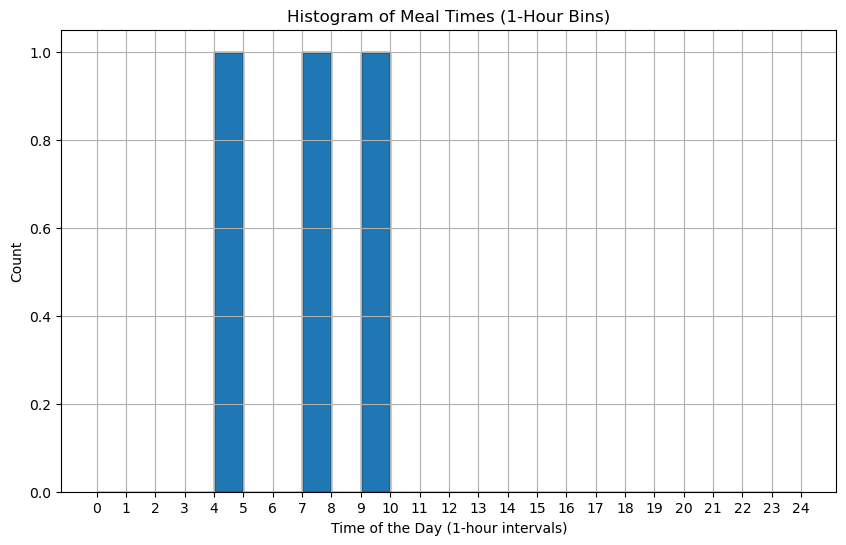

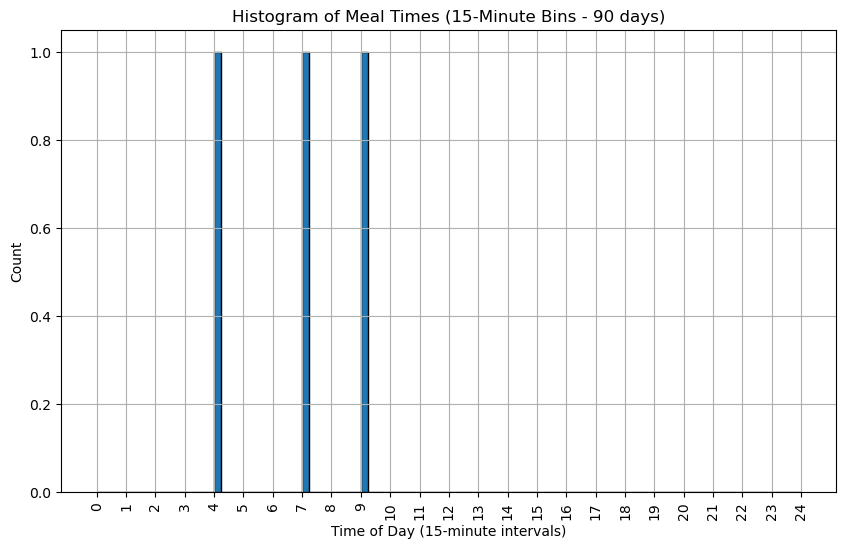

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_announce_meal_histogram(df, hours_or_15minutes='hours'):
    '''
    Plot a histogram of the 15-minute intervals of the day where 'ANNOUNCE_MEAL' occurs.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame with columns 'msg_type' and a datetime index.

    Returns
    -------
    None
    '''
    # Filter the DataFrame to include only 'ANNOUNCE_MEAL' events
    announce_meal_df = df[df['msg_type'] == 'ANNOUNCE_MEAL']

    # Extract the hour and minute from the timestamp
    announce_meal_hours = announce_meal_df.index.hour
    announce_meal_minutes = announce_meal_df.index.minute

    if hours_or_15minutes == 'minutes':
        # Convert the hour and minute into minutes to represent 15-minute intervals
        announce_meal_fractional_hours = announce_meal_hours + announce_meal_minutes / 60.0

        # Plot the histogram with 15-minute intervals (96 bins for 24 hours)
        plt.figure(figsize=(10, 6))
        plt.hist(announce_meal_fractional_hours, bins=96, range=(0, 24), edgecolor='black')
        plt.xlabel('Time of Day (15-minute intervals)')
        plt.ylabel('Count')
        plt.title('Histogram of Meal Times (15-Minute Bins - 90 days)')
        plt.xticks([i/4 for i in range(0, 24*4+1) if i % 4 == 0], rotation=90)
        plt.grid(True)
        plt.show()
        return

    elif hours_or_15minutes == 'hours':
        # Plot the histogram
        plt.figure(figsize=(10, 6))
        plt.hist(announce_meal_hours, bins=24, range=(0, 24), edgecolor='black')
        plt.xlabel('Time of the Day (1-hour intervals)')
        plt.ylabel('Count')
        plt.title('Histogram of Meal Times (1-Hour Bins)')
        plt.xticks(range(0, 25))
        plt.grid(True)
        plt.show()

# Example usage
data = {
    'msg_type': ['ANNOUNCE_MEAL', 'OTHER', 'OTHER', 'ANNOUNCE_MEAL', 'OTHER', 'ANNOUNCE_MEAL'],
    'food_g': [10, 5, 0, 20, 15, 25],
    'timestamp': pd.date_range(start='2023-01-01 04:00:00', periods=6, freq='H')
}
df = pd.DataFrame(data).set_index('timestamp')
plot_announce_meal_histogram(df, hours_or_15minutes='hours')
plot_announce_meal_histogram(df, hours_or_15minutes='minutes')

### Meal Distribution Times

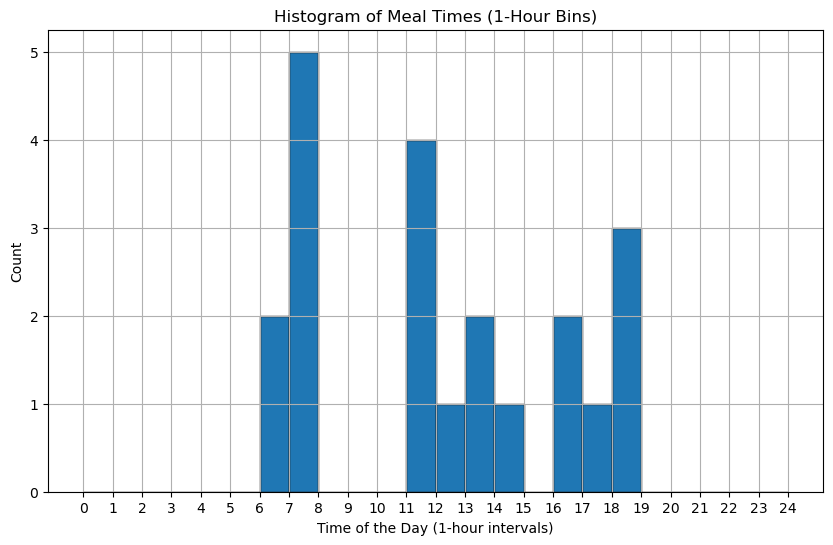

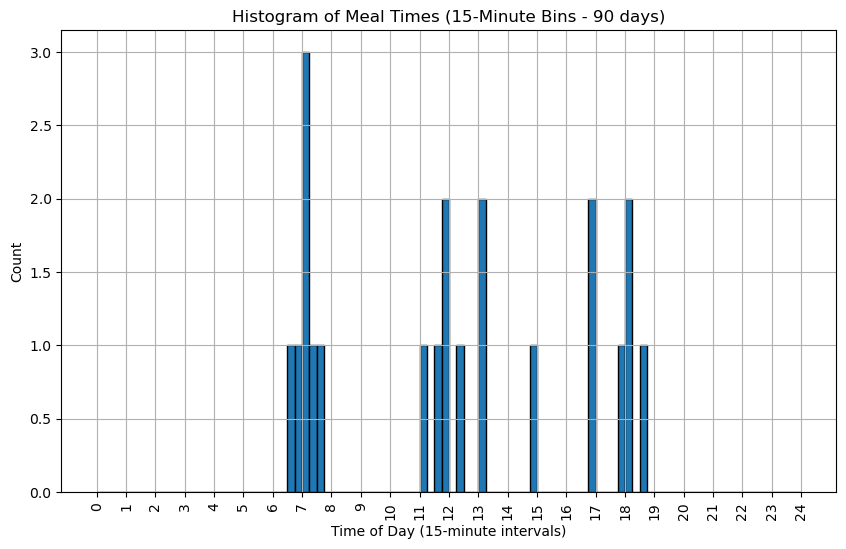

In [25]:
plot_announce_meal_histogram(walker_df, hours_or_15minutes='hours')
plot_announce_meal_histogram(walker_df, hours_or_15minutes='minutes')

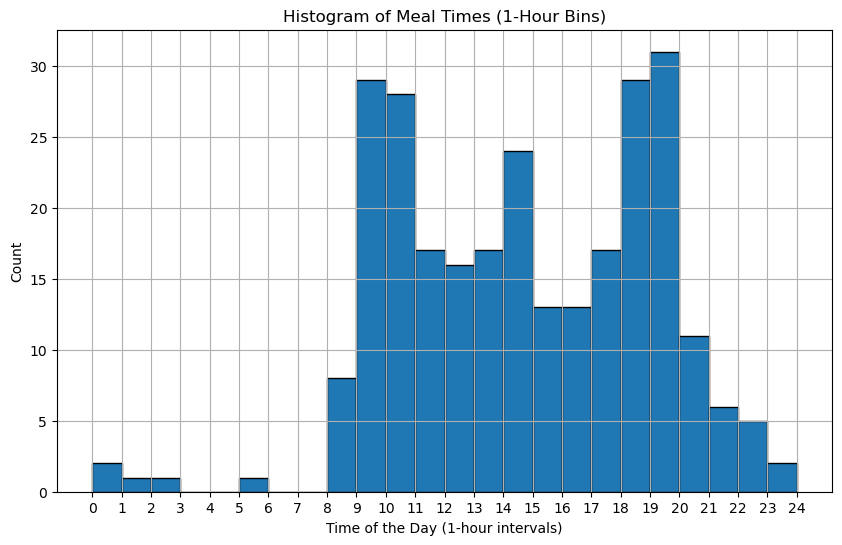

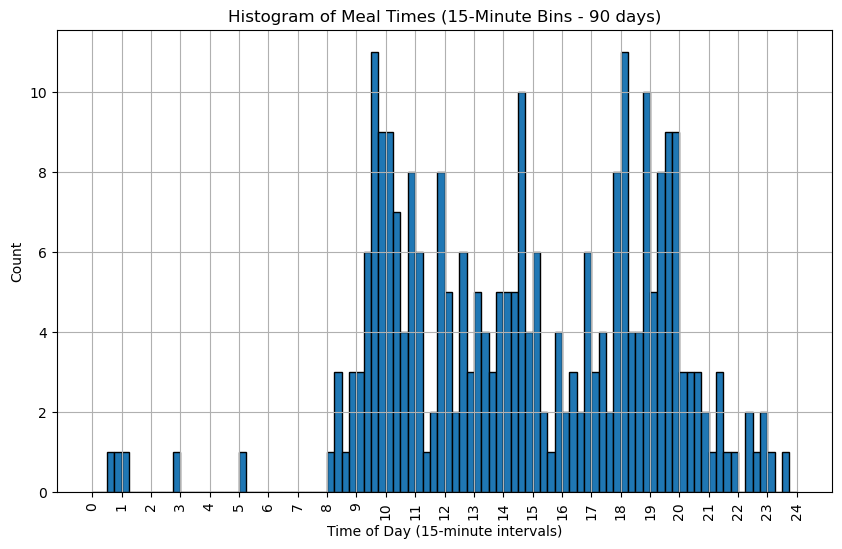

In [26]:
plot_announce_meal_histogram(christopher_df, hours_or_15minutes='hours')
plot_announce_meal_histogram(christopher_df, hours_or_15minutes='minutes')

## Dataset Creation Loop - Hyperparameters



In [27]:
from sklearn.model_selection import ParameterGrid

# Define the hyperparameter grid
param_grid = {
    'meal_length_window': [2, 3, 5],
    'n_top_carb_meals': [3, 4],
    'min_carbs': [5, 10]
}

# Create the grid of hyperparameter settings
grid = ParameterGrid(param_grid)

# Print the grid
for params in grid:
    print(params)

{'meal_length_window': 2, 'min_carbs': 5, 'n_top_carb_meals': 3}
{'meal_length_window': 2, 'min_carbs': 5, 'n_top_carb_meals': 4}
{'meal_length_window': 2, 'min_carbs': 10, 'n_top_carb_meals': 3}
{'meal_length_window': 2, 'min_carbs': 10, 'n_top_carb_meals': 4}
{'meal_length_window': 3, 'min_carbs': 5, 'n_top_carb_meals': 3}
{'meal_length_window': 3, 'min_carbs': 5, 'n_top_carb_meals': 4}
{'meal_length_window': 3, 'min_carbs': 10, 'n_top_carb_meals': 3}
{'meal_length_window': 3, 'min_carbs': 10, 'n_top_carb_meals': 4}
{'meal_length_window': 5, 'min_carbs': 5, 'n_top_carb_meals': 3}
{'meal_length_window': 5, 'min_carbs': 5, 'n_top_carb_meals': 4}
{'meal_length_window': 5, 'min_carbs': 10, 'n_top_carb_meals': 3}
{'meal_length_window': 5, 'min_carbs': 10, 'n_top_carb_meals': 4}


In [28]:
for ds_config in grid:
    print(ds_config)
    dataset_creator(meal_length=pd.Timedelta(hours=ds_config['meal_length_window']),
                    n_top_carb_meals=ds_config['n_top_carb_meals'],
                    min_carbs=ds_config['min_carbs'],
                    return_data=False)

{'meal_length_window': 2, 'min_carbs': 5, 'n_top_carb_meals': 3}
/home/cjrisi/Projects/bg_control
/home/cjrisi/Projects/bg_control/0_meal_identification/meal_identification/data/raw
Loaded DataFrames: ['adu001_2024-11-18_2024-11-25.csv', '500030_2024-07-01_2024-09-30.csv', 'adu003_2024-11-18_2024-11-25.csv', '679372_2024-07-01_2024-09-30.csv']

Processing: adu001
Erasing meal overlap with minCarb5g and 2hr meal window
Project root: /home/cjrisi/Projects/bg_control
Data saved successfully in: 0_meal_identification/meal_identification/data/interim

 	 Dataset label: 2024-11-28_adu001___timeInter5mins_dayStart4hrs_minCarb5g_2hrMealW

Processing: 500030
Erasing meal overlap with minCarb5g and 2hr meal window
Project root: /home/cjrisi/Projects/bg_control
Data saved successfully in: 0_meal_identification/meal_identification/data/interim

 	 Dataset label: 2024-11-28_500030___timeInter5mins_dayStart4hrs_minCarb5g_2hrMealW

Processing: adu003
Erasing meal overlap with minCarb5g and 2hr meal w